In [ ]:
# file_folder_path = 'benchmarking/results/old_results/'
file_folder_path = ''

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple, List, Dict
from scipy.stats import beta

# --- CI helpers (you already have these) ---
def _wilson_ci(num_success: np.ndarray, n: np.ndarray, z: float = 1.96) -> Tuple[np.ndarray, np.ndarray]:
    p_hat = np.divide(num_success, n, out=np.zeros_like(num_success, dtype=float), where=n>0)
    denom = 1.0 + (z**2)/n
    center = (p_hat + (z**2)/(2*n)) / denom
    half_width = (z * np.sqrt((p_hat*(1 - p_hat))/n + (z**2)/(4*(n**2)))) / denom
    lower = np.clip(center - half_width, 0.0, 1.0)
    upper = np.clip(center + half_width, 0.0, 1.0)
    return lower, upper

def _clopper_pearson_ci(num_success: np.ndarray, n: np.ndarray, alpha: float = 0.05) -> Tuple[np.ndarray, np.ndarray]:
    k = np.asarray(num_success, dtype=float)
    n = np.asarray(n, dtype=float)
    lower = beta.ppf(alpha/2, k, n - k + 1)
    upper = beta.ppf(1 - alpha/2, k + 1, n - k)
    lower = np.where(k == 0, 0.0, lower)
    upper = np.where(k == n, 1.0, upper)
    return lower, upper

def _safe_read(csv_path: str) -> pd.DataFrame:
    import csv
    try:
        return pd.read_csv(csv_path)
    except pd.errors.ParserError:
        rows = []
        with open(csv_path, "r", newline="") as f:
            reader = csv.reader(f)
            header = next(reader, [])
            for r in reader:
                if len(r) >= 10:
                    rows.append({
                        "model": r[6],
                        "raw_model_score": float(r[8]) if r[8] else 0.0,
                        "baymin_score": float(r[9]) if r[9] else 0.0,
                    })
        return pd.DataFrame(rows)

def plot_model_comparison(
    csv_file: str,
    models: List[str],
    color_list: List[str] = ['#1f77b4', '#ff7f0e'],
    model_name_dict: Optional[Dict[str, List[str]]] = None,
    metric_name: str = 'Score',
    x_axis: str = 'model',
    legend_name: str = 'Model Performance',
    title_name: str = 'Raw Model vs Baymin Model Comparison',
    plot_size: Tuple[int, int] = (12, 8),
    show_legend: bool = True,
    separate_bar_names: bool = True,
    show_grid: bool = False,
    baymin_csv_file: Optional[str] = None,
    ci_method: str = "wilson",          # "wilson" | "clopper" (binary only) | "normal"
    z_value: float = 1.96,              # for "wilson" and "normal"
    show_counts_on_bars: bool = True,
    show_number_on_bars: bool = True,
    err_bar_color: str = 'black'
):
    """
    Adds 95% confidence intervals to each bar. For 0/1 scores, uses binomial CIs.
    Otherwise falls back to normal-approximation CI on the mean.
    """

    # --- Load data ---
    df_raw_src = _safe_read(csv_file)
    df_bay_src = _safe_read(baymin_csv_file) if baymin_csv_file else df_raw_src

    # --- Filter models ---
    df_raw = df_raw_src[df_raw_src['model'].isin(models)]
    df_bay = df_bay_src[df_bay_src['model'].isin(models)]
    if df_raw.empty or df_bay.empty:
        print("No data found for the specified models in one or both files.")
        return

    # --- Aggregates per model ---
    def _is_binary(series: pd.Series) -> bool:
        s = series.dropna().astype(float)
        return not s.empty and set(np.unique(s)).issubset({0.0, 1.0})

    # raw
    raw_grp = df_raw.groupby('model')['raw_model_score']
    raw_mean = raw_grp.mean()
    raw_n    = raw_grp.count()
    raw_sum  = raw_grp.sum()  # for binomial

    # baymin
    bay_grp = df_bay.groupby('model')['baymin_score']
    bay_mean = bay_grp.mean()
    bay_n    = bay_grp.count()
    bay_sum  = bay_grp.sum()

    # Merge & keep order
    model_stats = (
        pd.concat([raw_mean.rename('raw_model_score'),
                   raw_n.rename('raw_n'),
                   raw_sum.rename('raw_success'),
                   bay_mean.rename('baymin_score'),
                   bay_n.rename('bay_n'),
                   bay_sum.rename('bay_success')], axis=1)
        .reindex(models)
        .dropna(how='all')
        .reset_index()
        .rename(columns={'index': 'model'})
    )
    if model_stats.empty:
        print("After merging, no overlapping models found between files.")
        return

    # --- Compute CIs ---
    def _ci_for_series(mean: np.ndarray, n: np.ndarray, success: np.ndarray,
                       binary: bool, method: str):
        if binary:
            if method == "clopper":
                lo, up = _clopper_pearson_ci(success, n)
            else:  # default wilson
                lo, up = _wilson_ci(success, n, z=z_value)
        else:
            # normal approx on the mean
            # need std per group
            std = mean.copy()
            std[:] = np.nan
            return std, std  # placeholder; will fill below
        return lo, up

    raw_is_binary = _is_binary(df_raw['raw_model_score'])
    bay_is_binary = _is_binary(df_bay['baymin_score'])

    # Binary cases
    if raw_is_binary:
        raw_lo, raw_up = _ci_for_series(
            model_stats['raw_model_score'].to_numpy(),
            model_stats['raw_n'].to_numpy(),
            model_stats['raw_success'].to_numpy(),
            True, ci_method
        )
    else:
        # continuous: std / sqrt(n)
        raw_std = df_raw.groupby('model')['raw_model_score'].std().reindex(models).to_numpy()
        raw_n_v = model_stats['raw_n'].to_numpy()
        se = np.divide(raw_std, np.sqrt(np.maximum(raw_n_v, 1)), out=np.zeros_like(raw_n_v, dtype=float), where=raw_n_v>0)
        raw_lo = np.clip(model_stats['raw_model_score'].to_numpy() - z_value*se, 0.0, 1.0)
        raw_up = np.clip(model_stats['raw_model_score'].to_numpy() + z_value*se, 0.0, 1.0)

    if bay_is_binary:
        bay_lo, bay_up = _ci_for_series(
            model_stats['baymin_score'].to_numpy(),
            model_stats['bay_n'].to_numpy(),
            model_stats['bay_success'].to_numpy(),
            True, ci_method
        )
    else:
        bay_std = df_bay.groupby('model')['baymin_score'].std().reindex(models).to_numpy()
        bay_n_v = model_stats['bay_n'].to_numpy()
        se = np.divide(bay_std, np.sqrt(np.maximum(bay_n_v, 1)), out=np.zeros_like(bay_n_v, dtype=float), where=bay_n_v>0)
        bay_lo = np.clip(model_stats['baymin_score'].to_numpy() - z_value*se, 0.0, 1.0)
        bay_up = np.clip(model_stats['baymin_score'].to_numpy() + z_value*se, 0.0, 1.0)

    # yerr must be 2 x N (lower distance, upper distance)
    raw_y = model_stats['raw_model_score'].to_numpy()
    bay_y = model_stats['baymin_score'].to_numpy()
    raw_yerr = np.vstack([np.maximum(0, raw_y - raw_lo), np.maximum(0, raw_up - raw_y)])
    bay_yerr = np.vstack([np.maximum(0, bay_y - bay_lo), np.maximum(0, bay_up - bay_y)])

    raw_y *= 100
    bay_y *= 100
    raw_yerr *= 100
    bay_yerr *= 100

    # --- Plot ---
    plt.figure(figsize=plot_size)
    x = np.arange(len(model_stats))
    width = 0.35

    bars1 = plt.bar(
        x - width/2, raw_y, width,
        yerr=raw_yerr, capsize=4, ecolor=err_bar_color,
        label='Raw Model', color=color_list[0], alpha=0.85, zorder=3
    )
    bars2 = plt.bar(
        x + width/2, bay_y, width,
        yerr=bay_yerr, capsize=4, ecolor=err_bar_color,
        label='Baymin Model', color=color_list[1], alpha=0.85, zorder=3
    )

    ax = plt.gca()
    pos_raw = x - width/2
    pos_bay = x + width/2

    # X tick labels
    if model_name_dict:
        raw_labels    = [model_name_dict.get(m, [f"{m} (Raw)", f"{m} (Baymin)"])[0]
                         for m in model_stats['model']]
        baymin_labels = [model_name_dict.get(m, [f"{m} (Raw)", f"{m} (Baymin)"])[1]
                         for m in model_stats['model']]
    else:
        raw_labels    = [f"{m} (Raw)"    for m in model_stats['model']]
        baymin_labels = [f"{m} (Baymin)" for m in model_stats['model']]

    if separate_bar_names:
        tick_positions = np.concatenate([pos_raw, pos_bay])
        tick_labels    = raw_labels + baymin_labels
        ax.set_xticks(tick_positions, tick_labels, rotation=0, fontsize=14)
    else:
        # Use mapped group labels when provided
        if model_name_dict:
            group_labels = [model_name_dict.get(m, [m, m])[0] for m in model_stats['model']]
        else:
            group_labels = list(model_stats['model'])
        ax.set_xticks(x, group_labels, rotation=0, fontsize=14)

    plt.xlabel(x_axis, fontsize=14)
    plt.ylabel(metric_name, fontsize=14)
    plt.title(title_name, fontsize=14, fontweight='bold')

    if show_legend:
        plt.legend(title=legend_name, fontsize=13)

    # value labels (and n)
    if show_number_on_bars:
        for bar, n_i in zip(bars1, model_stats['raw_n'].to_numpy()):
            h = bar.get_height()
            if not np.isnan(h):
                txt = f'{h:.3f}' + (f'\n(n={int(n_i)})' if show_counts_on_bars else '')
                plt.text(bar.get_x() + bar.get_width()/2., h + 0.01, txt, ha='center', va='bottom', fontsize=9)
        for bar, n_i in zip(bars2, model_stats['bay_n'].to_numpy()):
            h = bar.get_height()
            if not np.isnan(h):
                txt = f'{h:.3f}' + (f'\n(n={int(n_i)})' if show_counts_on_bars else '')
                plt.text(bar.get_x() + bar.get_width()/2., h + 0.01, txt, ha='center', va='bottom', fontsize=9)

    # tidy axes
    ax.set_axisbelow(True)
    plt.grid(show_grid, alpha=(0.3 if show_grid else 0), axis='y')
    plt.ylim(0, 100)                # adjust if your metric isn't bounded
    plt.yticks(np.arange(0, 101, 10))
    plt.tight_layout()
    plt.show()

    # --- Summary ---
    print("\nSummary Statistics (+ 95% CI):")
    print("=" * 60)
    for i, row in model_stats.iterrows():
        m = row['model']
        print(f"Model: {m}")
        print(f"  Raw:    {raw_y[i]:.3f}  (95% CI [{raw_y[i]-raw_yerr[0,i]:.3f}, {raw_y[i]+raw_yerr[1,i]:.3f}], n={int(row['raw_n'])})")
        print(f"  Baymin: {bay_y[i]:.3f}  (95% CI [{bay_y[i]-bay_yerr[0,i]:.3f}, {bay_y[i]+bay_yerr[1,i]:.3f}], n={int(row['bay_n'])})")
        if np.isfinite(raw_y[i]) and np.isfinite(bay_y[i]):
            diff = bay_y[i] - raw_y[i]
            print(f"  Δ (Baymin - Raw): {diff:+.3f}")
        print("-" * 60)

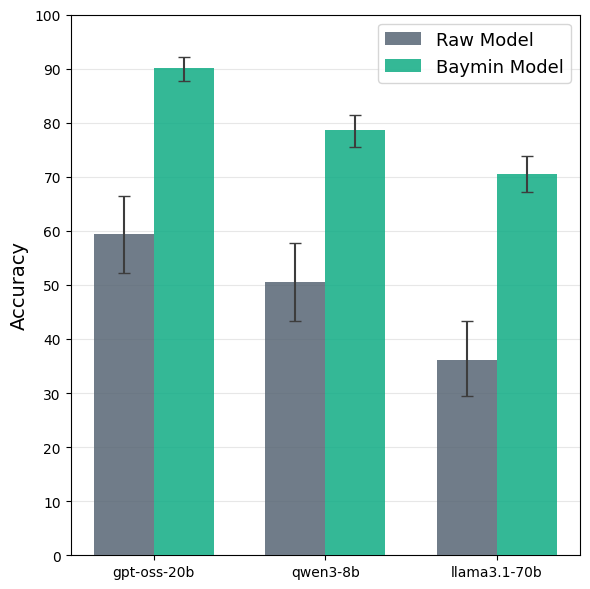


Summary Statistics (+ 95% CI):
Model: gpt-oss:latest
  Raw:    59.444  (95% CI [52.147, 66.347], n=180)
  Baymin: 90.139  (95% CI [87.743, 92.108], n=720)
  Δ (Baymin - Raw): +30.694
------------------------------------------------------------
Model: qwen3:8b
  Raw:    50.556  (95% CI [43.317, 57.771], n=180)
  Baymin: 78.611  (95% CI [75.468, 81.450], n=720)
  Δ (Baymin - Raw): +28.056
------------------------------------------------------------
Model: llama3.1:70b
  Raw:    36.111  (95% CI [29.452, 43.351], n=180)
  Baymin: 70.556  (95% CI [67.124, 73.769], n=720)
  Δ (Baymin - Raw): +34.444
------------------------------------------------------------


In [46]:
# Test with all available models
plot_model_comparison(
    csv_file='test_log.csv',                 # raw side
    baymin_csv_file='baymin_test_log.csv',       # baymin side
    models=['gpt-oss:latest', 'qwen3:8b', 'llama3.1:70b'],
    color_list=['#576574', '#10ac84'],  
    model_name_dict={
        'gpt-oss:latest': ['gpt-oss-20b', 'BayMin-gpt-oss-20b'],
        'qwen3:8b': ['qwen3-8b', 'BayMin-qwen3-8b'],
        'llama3.1:70b': ['llama3.1-70b', 'BayMin-llama3.1-70b']
    },
    metric_name='Accuracy',
    x_axis='',
    legend_name='',
    title_name='',
    plot_size=(6, 6),
    separate_bar_names=False,   # or True if you want alternating labels
    show_grid=True,
    show_counts_on_bars=False,
    show_number_on_bars=False,
    err_bar_color='#3D3D3D'
)

In [33]:
def plot_baymin_accuracy_with_ci(
    csv_file: str,
    x_axis: str = "network_size",
    x_axis_label: str = "Network Size",
    title: str = "Baymin Accuracy with 95% CI",
    figsize: Tuple[int, int] = (12, 6),
    sort_by_time: bool = True,
    rolling_window: Optional[int] = None,
    grid: bool = True,
    aggregate_by_x: Optional[bool] = None,
    ci_method: str = "clopper",  # "clopper" (exact) or "wilson"

    # NEW: multi-model support
    models: Optional[List[str]] = None,                          # which models to include (None = all)
    model_display_names: Optional[Dict[str, str]] = None,        # optional pretty names per model
    color_map: Optional[Dict[str, str]] = None,                  # per-model line color
    default_colors: Optional[List[str]] = None,                  # fallback color cycle

    # Style (kept for backward compat; used as fallbacks)
    mean_line_color: str = "#1f77b4",
    ci_alpha: float = 0.15,
    error_bar_capsize: float = 3.0,
    show_number_on_bars: bool = True,
):
    """
    Plot Baymin accuracy with 95% CI for one or multiple models.

    Two modes:
    1) aggregate_by_x=True  -> mean accuracy per x-bin with error bars (per model)
    2) aggregate_by_x=False -> sequential cumulative plot with CI shading (per model)

    Multi-model:
      - Pass `models=['gpt-oss:latest','qwen3:8b']` to include specific models.
      - `color_map={'gpt-oss:latest':'#1f77b4','qwen3:8b':'#ff7f0e'}` to customize colors.
      - `model_display_names={'gpt-oss:latest':'GPT-OSS','qwen3:8b':'Qwen3-8B'}` for legend labels.
    """
    df = pd.read_csv(csv_file)

    if 'baymin_score' not in df.columns:
        raise ValueError("CSV must contain 'baymin_score' column (0/1).")
    if 'model' not in df.columns:
        raise ValueError("CSV must contain 'model' column for multi-model plotting.")

    # Select models
    all_models_in_data = sorted(df['model'].dropna().unique().tolist())
    if models is None or len(models) == 0:
        models = all_models_in_data
    else:
        # keep only those present
        models = [m for m in models if m in all_models_in_data]
        if len(models) == 0:
            raise ValueError("None of the requested `models` exist in the CSV.")

    # Colors
    if color_map is None:
        color_map = {}
    if default_colors is None or len(default_colors) == 0:
        default_colors = plt.rcParams['axes.prop_cycle'].by_key().get('color', [
            "#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
            "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf"
        ])

    # Fill missing colors from default cycle
    color_cycle_idx = 0
    for m in models:
        if m not in color_map or color_map[m] is None:
            if color_cycle_idx < len(default_colors):
                color_map[m] = default_colors[color_cycle_idx]
                color_cycle_idx += 1
            else:
                color_map[m] = mean_line_color  # fallback

    # Decide mode
    if aggregate_by_x is None:
        aggregate_by_x = x_axis in df.columns and x_axis != 'timestamp'

    # CI function
    def _ci_fn(success: np.ndarray, n: np.ndarray):
        if ci_method == "clopper":
            return _clopper_pearson_ci(success, n)
        else:
            return _wilson_ci(success, n)

    # ---------- Mode 1: Aggregate by x with per-model error bars ----------
    if aggregate_by_x and (x_axis in df.columns):
        plt.figure(figsize=figsize)
        # make x numeric if needed
        x_series_all = pd.to_numeric(df[x_axis], errors='coerce') if df[x_axis].dtype == object else df[x_axis]
        df = df.assign(_x=x_series_all).dropna(subset=['_x'])

        for m in models:
            sub = df[df['model'] == m].copy()
            if sub.empty:
                continue
            sub['_y'] = sub['baymin_score'].fillna(0).astype(float)
            grouped = sub.groupby('_x').agg(num_success=('_y', 'sum'), n=('_y', 'size')).reset_index()
            grouped = grouped.sort_values('_x')
            if grouped.empty:
                continue

            acc = grouped['num_success'] / grouped['n']
            lo, up = _ci_fn(grouped['num_success'].to_numpy(), grouped['n'].to_numpy())
            x_vals = grouped['_x'].to_numpy()
            yerr = np.vstack([acc - lo, up - acc])

            acc *= 100
            yerr *= 100

            label = model_display_names.get(m, m) if model_display_names else m
            plt.errorbar(
                x_vals, acc, yerr=yerr, fmt='o-', capsize=error_bar_capsize,
                label=label, color=color_map[m]
            )

        plt.yticks(np.arange(0, 101, 10))
        plt.ylim(0, 100)
        plt.xlabel(x_axis_label)
        plt.ylabel('Accuracy')
        plt.title(title)
        if grid:
            plt.grid(True, axis='y', alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()
        return

    # ---------- Mode 2: Sequential cumulative per model with CI shading ----------
    plt.figure(figsize=figsize)

    for m in models:
        sub = df[df['model'] == m].copy()
        if sub.empty:
            continue

        # sorting
        if sort_by_time and 'timestamp' in sub.columns:
            try:
                sub['_ts'] = pd.to_datetime(sub['timestamp'])
                sub = sub.sort_values('_ts').reset_index(drop=True)
            except Exception:
                sub = sub.sort_values(x_axis if x_axis in sub.columns else 'index').reset_index(drop=True)
        else:
            sub = sub.sort_values(x_axis if x_axis in sub.columns else 'index').reset_index(drop=True)

        # x sequence
        x_seq = np.arange(1, len(sub)+1)
        if x_axis in sub.columns:
            x_candidate = sub[x_axis].to_numpy()
            has_dup = pd.Series(x_candidate).duplicated().any()
            is_mono = pd.Series(x_candidate).is_monotonic_increasing
            x_vals = x_seq if (has_dup or not is_mono) else x_candidate
        else:
            x_vals = x_seq

        # cumulative accuracy + CI
        y = sub['baymin_score'].fillna(0).astype(float).to_numpy()
        if len(y) == 0:
            continue
        cum_success = np.cumsum(y)
        n = np.arange(1, len(y)+1)
        cum_acc = cum_success / n
        lower, upper = _wilson_ci(cum_success, n) if ci_method != "clopper" else _clopper_pearson_ci(cum_success, n)

        label = model_display_names.get(m, m) if model_display_names else m
        plt.plot(x_vals, cum_acc, color=color_map[m], label=label, linewidth=2)
        plt.fill_between(x_vals, lower, upper, color=color_map[m], alpha=ci_alpha, label=f"{label} 95% CI")

        # optional rolling mean per model
        if rolling_window and rolling_window > 1:
            roll = pd.Series(y).rolling(rolling_window, min_periods=max(1, rolling_window//2)).mean().to_numpy()
            plt.plot(x_vals, roll, color=color_map[m], linestyle='--', linewidth=1.5, label=f"{label} Rolling ({rolling_window})")

    plt.ylim(0, 100)
    plt.xlabel(x_axis if x_axis in df.columns else 'index')
    plt.ylabel('Accuracy')
    plt.title(title)
    if grid:
        plt.grid(True, axis='y', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

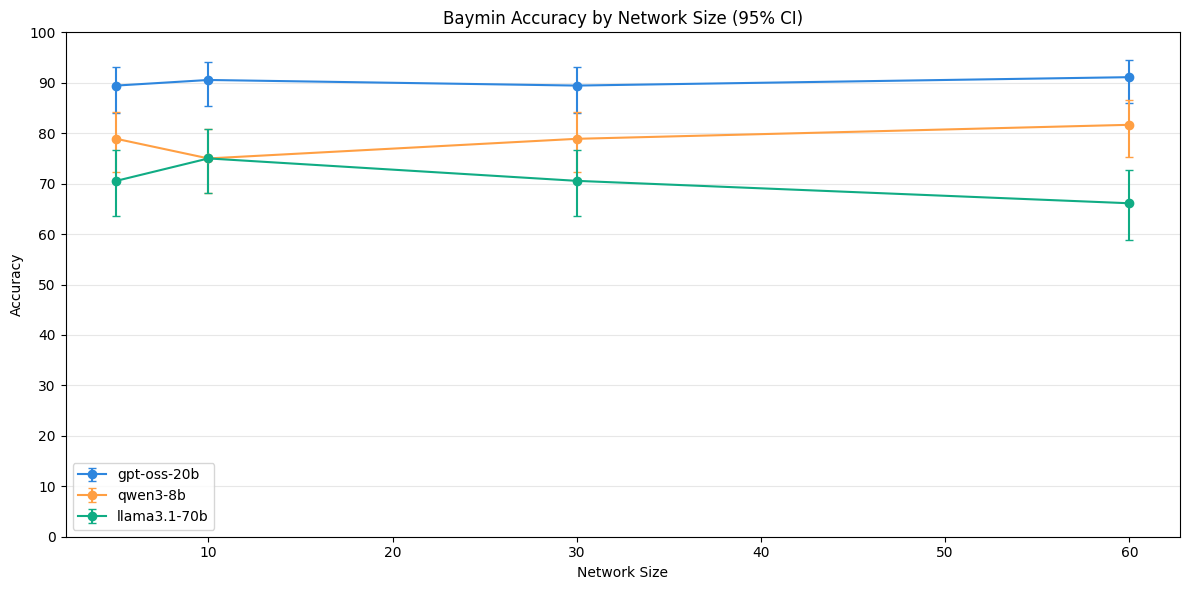

In [34]:
file_folder_path = ''

plot_baymin_accuracy_with_ci(
    csv_file=file_folder_path + 'baymin_test_log.csv',
    x_axis='network_size',
    x_axis_label='Network Size',
    title='Baymin Accuracy by Network Size (95% CI)',
    aggregate_by_x=True,
    ci_method='wilson',
    models=['gpt-oss:latest','qwen3:8b','llama3.1:70b'],
    model_display_names={'gpt-oss:latest':'gpt-oss-20b','qwen3:8b':'qwen3-8b','llama3.1:70b':'llama3.1-70b'},
    color_map={'gpt-oss:latest':'#2e86de','qwen3:8b':'#ff9f43','llama3.1:70b':'#10ac84'},
)